# Cupy
A subset of NumPy with GPU support. 

https://cupy.dev/

In [1]:
import numpy as np
import cupy as cp

Check for available devices

In [2]:
for i in range(cp.cuda.runtime.getDeviceCount()):
    cp.cuda.runtime.setDevice(i)
    free,total=cp.cuda.runtime.memGetInfo()
    print(f"Device {i}: {round(free/1E9,0)}GB/{round(total/1E9,0)}GB" )

Device 0: 34.0GB/34.0GB
Device 1: 34.0GB/34.0GB


If there are multiple devices we can chose one

In [3]:
cp.cuda.runtime.setDevice(0)

Allocating array in CPU

In [4]:
x_cpu = np.arange(100)

Allocating array in GPU

In [5]:
x_gpu = cp.arange(100)

We can for instance, compute the mean value these arrays.

First in CPU with the usual NumPy function

In [6]:
np.mean(x_cpu)

49.5

And now in GPU with the respective CuPy function 

In [7]:
cp.mean(x_gpu)

array(49.5)

CuPy provides functions to convert or move data from GPU to CPU or viceversa

In [8]:
x_cpu = np.arange(100)
x_gpu = cp.asarray(x_cpu)
type(x_gpu)

cupy._core.core.ndarray

In [9]:
x_gpu = cp.arange(100)      
x_cpu = cp.asnumpy(x_gpu)   
type(x_cpu)

numpy.ndarray

In [10]:
x_cpu = x_gpu.get()
type(x_cpu)

numpy.ndarray

# Agnostic code

We can write functions that operate on either host or device

In [11]:
# Stable implementation of log(1 + exp(x))
def softplus(x):
    xp = cp.get_array_module(x)
    return xp.maximum(0, x) + xp.log1p(xp.exp(-abs(x)))

In [12]:
softplus(x_cpu)

array([ 0.69314718,  1.31326169,  2.12692801,  3.04858735,  4.01814993,
        5.00671535,  6.00247569,  7.00091147,  8.00033541,  9.0001234 ,
       10.0000454 , 11.0000167 , 12.00000614, 13.00000226, 14.00000083,
       15.00000031, 16.00000011, 17.00000004, 18.00000002, 19.00000001,
       20.        , 21.        , 22.        , 23.        , 24.        ,
       25.        , 26.        , 27.        , 28.        , 29.        ,
       30.        , 31.        , 32.        , 33.        , 34.        ,
       35.        , 36.        , 37.        , 38.        , 39.        ,
       40.        , 41.        , 42.        , 43.        , 44.        ,
       45.        , 46.        , 47.        , 48.        , 49.        ,
       50.        , 51.        , 52.        , 53.        , 54.        ,
       55.        , 56.        , 57.        , 58.        , 59.        ,
       60.        , 61.        , 62.        , 63.        , 64.        ,
       65.        , 66.        , 67.        , 68.        , 69.  

In [13]:
softplus(x_gpu)

array([ 0.69314718,  1.31326169,  2.12692801,  3.04858735,  4.01814993,
        5.00671535,  6.00247569,  7.00091147,  8.00033541,  9.0001234 ,
       10.0000454 , 11.0000167 , 12.00000614, 13.00000226, 14.00000083,
       15.00000031, 16.00000011, 17.00000004, 18.00000002, 19.00000001,
       20.        , 21.        , 22.        , 23.        , 24.        ,
       25.        , 26.        , 27.        , 28.        , 29.        ,
       30.        , 31.        , 32.        , 33.        , 34.        ,
       35.        , 36.        , 37.        , 38.        , 39.        ,
       40.        , 41.        , 42.        , 43.        , 44.        ,
       45.        , 46.        , 47.        , 48.        , 49.        ,
       50.        , 51.        , 52.        , 53.        , 54.        ,
       55.        , 56.        , 57.        , 58.        , 59.        ,
       60.        , 61.        , 62.        , 63.        , 64.        ,
       65.        , 66.        , 67.        , 68.        , 69.  

In [14]:
cp.get_array_module(x_gpu)

<module 'cupy' from '/home/dv9346/.local/lib/python3.9/site-packages/cupy/__init__.py'>

In [15]:
cp.get_array_module(x_cpu)

<module 'numpy' from '/usr/licensed/anaconda3/2021.11/lib/python3.9/site-packages/numpy/__init__.py'>

In [16]:
from timeit import default_timer as timer

In [67]:
N=1000000
x_gpu = cp.arange(N)
x_cpu = np.arange(N)

reps=1000
time_cpu = -timer()
for i in range(reps):
    softplus(x_cpu)
time_cpu += timer()
print(time_cpu)

time_gpu = -timer()
for i in range(reps):
    softplus(x_gpu)
time_gpu += timer()
print(time_gpu)

print("Speed-up = ",time_cpu/time_gpu)

8.306322689866647
0.10346968309022486
Speed-up =  80.27784025030395


In [71]:
y_cpu = np.arange(N)+1

In [72]:
x_gpu + y_cpu

TypeError: Unsupported type <class 'numpy.ndarray'>

In [73]:
x_gpu + cp.asarray(y_cpu)

array([      1,       3,       5, ..., 1999995, 1999997, 1999999])

In [74]:
cp.asnumpy(x_gpu) + y_cpu

array([      1,       3,       5, ..., 1999995, 1999997, 1999999])

In [75]:
def softplus_gpu(x):
    if cp.get_array_module(x)!= cp:
        x = cp.asarray(x)
    return cp.maximum(0, x) + cp.log1p(cp.exp(-abs(x)))

In [76]:
softplus_gpu(x_cpu)

array([6.93147181e-01, 1.31326169e+00, 2.12692801e+00, ...,
       9.99997000e+05, 9.99998000e+05, 9.99999000e+05])

# Data Manager
We can desing an data manager in which to include all the arrays to be used in GPU, and let this data manager move the data between CPU and GPU. Effectively hidding all the copies

This data manager was designed by Quentin Wenger.

In [77]:
from enum import Enum

class CupyLocation(Enum):
    device = 0
    host = 1

In [78]:
class GPUData:
    def __init__(self, instance, value):
        self.values = {}
        self._set(instance, value)
    def __get__(self, instance, owner):
        if instance is None:
            return self
        icl = instance.current_location
        if icl != self.current_location:
            self.values[icl] = instance.convert_value(self.values[self.current_location])
            self.current_location = icl
        return self.values[icl]
    def __set__(self, instance, value):
        self._set(instance, value)
    def _set(self, instance, value):
        self.values[instance.current_location] = instance.convert_value(value)
        self.current_location = instance.current_location

In [79]:
def GPUDataManager(use_gpu: bool):
    class GPUDM:
        def __init__(self, use_gpu: bool):
            super().__setattr__("use_gpu", use_gpu)
            super().__setattr__("current_location", CupyLocation.host)
        def convert_value(self, value):
            if isinstance(value, np.ndarray) and self.current_location == CupyLocation.device:
                return cp.asarray(value)
            elif isinstance(value, cp.ndarray) and self.current_location == CupyLocation.host:
                return cp.asnumpy(value)
            return value
        def switch_to(self, location: CupyLocation):
            if not self.use_gpu:
                return
            self.current_location = location
        def __setattr__(self, key, value):
            if hasattr(self, key):
                super().__setattr__(key, value)
            else:
                setattr(type(self), key, GPUData(self, value))
        @property
        def xp(self):
            return {CupyLocation.host: np, CupyLocation.device: cp}[self.current_location]
    return GPUDM(use_gpu)

In [80]:
dm = GPUDataManager(True)

In [81]:
dm.x = np.arange(10000)

In [82]:
dm.x

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [83]:
dm.y = np.arange(10000)

In [84]:
dm.y

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [85]:
dm.y + dm.x

array([    0,     2,     4, ..., 19994, 19996, 19998])

In [86]:
cp.get_array_module(dm.x)

<module 'numpy' from '/usr/licensed/anaconda3/2021.11/lib/python3.9/site-packages/numpy/__init__.py'>

In [92]:
dm.switch_to(CupyLocation.device)

In [104]:
start = timer()
for i in range(reps):
    cp.power(dm.x,3)
timer()-start

0.013209959026426077

In [105]:
start = timer()
for i in range(reps):
    np.power(dm.x,3)
timer()-start

0.018290454987436533

In [107]:
start = timer()
for i in range(reps):
    dm.xp.power(dm.x,3)
timer()-start

0.014193394919857383

In [108]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 15

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

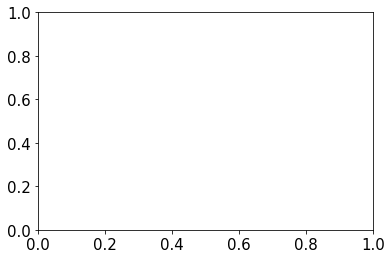

In [109]:
plt.plot(dm.x)

In [110]:
cp.get_array_module(dm.x)

<module 'cupy' from '/home/dv9346/.local/lib/python3.9/site-packages/cupy/__init__.py'>

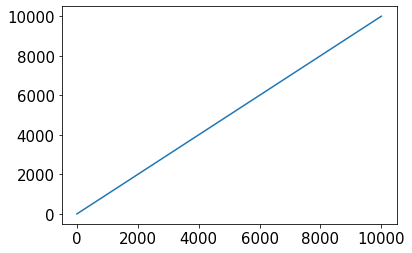

In [111]:
dm.switch_to(CupyLocation.host)
plt.plot(dm.x)

# User defined kernels
## ElementwiseKernel

In [46]:
squared_diff = cp.ElementwiseKernel(
   'float32 x, float32 y',
   'float32 z',
   'z = (x - y) * (x - y)',
   'squared_diff')

In [47]:
x = cp.arange(10, dtype=np.float32).reshape(2, 5)
y = cp.arange(5, dtype=np.float32)
squared_diff(x, y)

array([[ 0.,  0.,  0.,  0.,  0.],
       [25., 25., 25., 25., 25.]], dtype=float32)

In [48]:
squared_diff(x, 5)

array([[25., 16.,  9.,  4.,  1.],
       [ 0.,  1.,  4.,  9., 16.]], dtype=float32)

In [49]:
z = cp.empty((2, 5), dtype=np.float32)
squared_diff(x, y, z)

array([[ 0.,  0.,  0.,  0.,  0.],
       [25., 25., 25., 25., 25.]], dtype=float32)

## Generic types

In [50]:
squared_diff_generic = cp.ElementwiseKernel(
    'T x, T y',
    'T z',
    'z = (x - y) * (x - y)',
    'squared_diff_generic')

In [51]:
squared_diff_generic(x,5)

array([[25., 16.,  9.,  4.,  1.],
       [ 0.,  1.,  4.,  9., 16.]], dtype=float32)

## RawKernel

In [52]:
add_kernel = cp.RawKernel(r'''
extern "C" __global__
void my_add(const float* x1, const float* x2, float* y) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    y[tid] = x1[tid] + x2[tid];
}
''', 'my_add')
x1 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
x2 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
y = cp.zeros((5, 5), dtype=cp.float32)
add_kernel((5,), (5,), (x1, x2, y))  # grid, block and arguments
y

array([[ 0.,  2.,  4.,  6.,  8.],
       [10., 12., 14., 16., 18.],
       [20., 22., 24., 26., 28.],
       [30., 32., 34., 36., 38.],
       [40., 42., 44., 46., 48.]], dtype=float32)

## RawModule

In [54]:
loaded_from_source = r'''
extern "C"{

__global__ void test_sum(const float* x1, const float* x2, float* y, \
                         unsigned int N)
{
    unsigned int tid = blockDim.x * blockIdx.x + threadIdx.x;
    if (tid < N)
    {
        y[tid] = x1[tid] + x2[tid];
    }
}

__global__ void test_multiply(const float* x1, const float* x2, float* y, \
                              unsigned int N)
{
    unsigned int tid = blockDim.x * blockIdx.x + threadIdx.x;
    if (tid < N)
    {
        y[tid] = x1[tid] * x2[tid];
    }
}

}'''
module = cp.RawModule(code=loaded_from_source)
ker_sum = module.get_function('test_sum')
ker_times = module.get_function('test_multiply')
N = 10
x1 = cp.arange(N**2, dtype=cp.float32).reshape(N, N)
x2 = cp.ones((N, N), dtype=cp.float32)
y = cp.zeros((N, N), dtype=cp.float32)
#ker_sum((N,), (N,), (x1, x2, y, N**2))   # y = x1 + x2
#assert cp.allclose(y, x1 + x2)

#assert cp.allclose(y, x1 * x2)

In [68]:
x1

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.],
       [40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
       [50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
       [60., 61., 62., 63., 64., 65., 66., 67., 68., 69.],
       [70., 71., 72., 73., 74., 75., 76., 77., 78., 79.],
       [80., 81., 82., 83., 84., 85., 86., 87., 88., 89.],
       [90., 91., 92., 93., 94., 95., 96., 97., 98., 99.]], dtype=float32)

In [55]:
x2

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [56]:
ker_sum((N,), (N,), (x1, x2, y, N**2))   # y = x1 + x2
y

array([[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.],
       [ 21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.],
       [ 31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.],
       [ 41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.],
       [ 51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.],
       [ 61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.],
       [ 71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.],
       [ 81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.],
       [ 91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.]],
      dtype=float32)

In [57]:
ker_times((N,), (N,), (x1, x2, y, N**2)) # y = x1 * x2
y

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.],
       [40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
       [50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
       [60., 61., 62., 63., 64., 65., 66., 67., 68., 69.],
       [70., 71., 72., 73., 74., 75., 76., 77., 78., 79.],
       [80., 81., 82., 83., 84., 85., 86., 87., 88., 89.],
       [90., 91., 92., 93., 94., 95., 96., 97., 98., 99.]], dtype=float32)